In [1]:
import git
from pathlib import Path
import os
from matplotlib import colors

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
np.random.seed(0)

In [2]:
SAVE_FIGS = True
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "draft_plots")

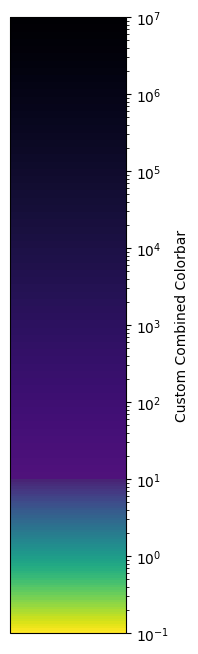

In [3]:
from matplotlib.colors import ListedColormap, LogNorm
import numpy as np
import matplotlib.pyplot as plt

# Set the split ratio (e.g., 0.25 means 25% viridis_r, 75% magma_r)
split_ratio = 0.25
n_total = 256
n1 = int(n_total * split_ratio)
n2 = n_total - n1

# Get color arrays from the colormaps
viridis_r = plt.get_cmap('viridis_r')(np.linspace(0, 0.9, n1))
magma_r = plt.get_cmap('magma_r')(np.linspace(0.75, 1, n2))

# Concatenate the color arrays
combined_colors = np.vstack([viridis_r, magma_r])
custom_cmap = ListedColormap(combined_colors)
def color_fn(variance):
        return custom_cmap(norm(variance))

# Create a colorbar for demonstration
fig, ax = plt.subplots(figsize=(1.5, 8))
norm = LogNorm(vmin=0.1, vmax=1e7)
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=custom_cmap), cax=ax)
cb.set_label('Custom Combined Colorbar')
plt.show()

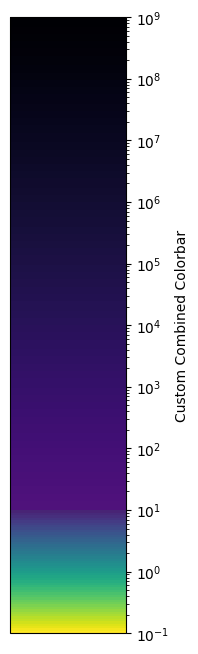

In [4]:
from matplotlib.colors import ListedColormap, LogNorm
import numpy as np
import matplotlib.pyplot as plt

# Set the split ratio (e.g., 0.25 means 25% viridis_r, 75% magma_r)
split_ratio = 0.2
n_total = 256
n1 = int(n_total * split_ratio)
n2 = n_total - n1

# Get color arrays from the colormaps
viridis_r = plt.get_cmap('viridis_r')(np.linspace(0, 0.9, n1))
magma_r = plt.get_cmap('magma_r')(np.linspace(0.75, 1, n2))

# Concatenate the color arrays
combined_colors = np.vstack([viridis_r, magma_r])
custom_cmap = ListedColormap(combined_colors)
def color_fn(variance):
        return custom_cmap(norm(variance))

# Create a colorbar for demonstration
fig, ax = plt.subplots(figsize=(1.5, 8))
norm = LogNorm(vmin=0.1, vmax=1e9)
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=custom_cmap), cax=ax)
cb.set_label('Custom Combined Colorbar')
plt.show()

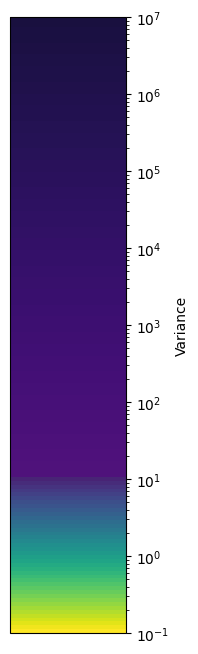

In [5]:
from matplotlib.colors import ListedColormap, LogNorm
import numpy as np
import matplotlib.pyplot as plt

# Set the split ratio (e.g., 0.25 means 25% viridis_r, 75% magma_r)
split_ratio = 0.16
n_total = 256
n1 = int(n_total * split_ratio)
n2 = n_total - n1

# Get color arrays from the colormaps
viridis_r = plt.get_cmap('viridis_r')(np.linspace(0, 0.9, n1))
magma_r = plt.get_cmap('magma_r')(np.linspace(0.75, 1, n2))

# Concatenate the color arrays
combined_colors = np.vstack([viridis_r, magma_r])
custom_cmap = ListedColormap(combined_colors)
def color_fn(variance):
        return custom_cmap(norm(variance))

# Create a colorbar for demonstration
fig, ax = plt.subplots(figsize=(1.5, 8))
norm = LogNorm(vmin=0.1, vmax=1e12)
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=custom_cmap), cax=ax)
cb.set_label('Variance')
plt.ylim((1e-1, 1e7))
plt.show()
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"varianceColorBar.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

In [6]:
def plot_pdf_components(r, eta, scale, components = 10, mode = "equal", color_fn = None, custom_var = None, varlim = None, xlim = None, lin_lim = None, log_lim = None, debug = True, prior_pdf = None, title = None, edgecolor = 'black'):
    beta = (eta + 1.5) / r
    
    if mode == "equal":
        x = np.linspace(0, 1, components+2)[1:-1][::-1]  # Exclude 0 and 1 to avoid singularities
        vars = stats.gengamma(a=beta, c=r, scale=scale).ppf(x)
        weights = np.ones(components) / components
    elif mode == "variance":
        if custom_var is None and varlim is None:
            raise ValueError("Either custom_var or varlim must be provided for 'variance' mode.")
        if custom_var is not None:
            vars = np.array(custom_var)
        elif varlim is not None:
            if varlim[2] == "linear":
                vars = np.linspace(varlim[0], varlim[1], components)[::-1]
            elif varlim[2] == "log":
                vars = np.logspace(np.log10(varlim[0]), np.log10(varlim[1]), components)[::-1]
        weights = stats.gengamma(a = beta, c = r, scale=scale).cdf(vars[::-1])
        weights = np.diff(weights, prepend=0)[::-1]
        print(sum(weights))  # Convert cumulative weights to densities
        print(weights)
        
    if prior_pdf is None:
        xs, genGamma_prior = compute_prior_pdf(r=r, eta=eta, scale=scale, n_samples=2000, debug=debug)
    else:
        xs = np.linspace(-5, 5, 1000)
        genGamma_prior = prior_pdf

    means = np.zeros(components)
    print(vars)
    norm_pdfs = np.array([stats.norm.pdf(xs, loc=mean, scale=np.sqrt(var)) for mean, var in zip(means, vars)])
    if color_fn is None:
        cmap = plt.cm.viridis(np.linspace(0, 1, components))
    else:
        cmap = [color_fn(var) for var in vars]  # Create a colormap based on the variances

    # Create side-by-side subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True, constrained_layout=True)

    for ax, yscale in zip(axs, ['linear', 'log']):
    # Plot stackplot
        ax.stackplot(
            xs,
            *(norm_pdfs * weights[:, None]),
            colors=cmap,
            labels=[f'Component {i+1} (var={vars[i]:.2f}), (wt={weights[i]:.2f})' for i in range(components)]
        )
        # Overlay the GenGamma prior
        ax.plot(xs, genGamma_prior(xs), label='GenGamma Prior', color='black', linestyle='--', linewidth=2)

        # Set styles
        for polygon in ax.collections:
            polygon.set_edgecolor(edgecolor)
        ax.set_xlabel(r'$x$')
        ax.set_yscale(yscale)
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.tick_params(axis='both', which='minor', labelsize=20)
        ax.xaxis.label.set_fontsize(20)
        ax.yaxis.label.set_fontsize(20)

    axs[0].set_ylabel(r'$\pi (x)$')

    # Shared title and colorbar
    if xlim is not None:
        axs[0].set_xlim(xlim)
        axs[1].set_xlim(xlim)
    if lin_lim is not None:
        axs[0].set_ylim(lin_lim)
    if log_lim is not None:
        axs[1].set_ylim(log_lim)

    if title is None:
        title = f'Scale Mixture of Normals with GenGamma Prior\nr={r}, eta={eta}, scale={scale}, components={components}'
    fig.suptitle(title, fontsize=20)



    # Add colorbar outside the plots
    #sm = plt.cm.ScalarMappable(
        #cmap=plt.cm.viridis_r,  # reversed colormap
        #norm=colors.Normalize(vmin=vars.min(), vmax=vars.max())
    #)  
    #sm.set_array([])
    #cbar = fig.colorbar(sm, ax=axs.ravel().tolist(), location='right', pad=0.02, aspect=40)
    #cbar.set_label('Variance')

    # Only show legend for the first axis, outside the plot
    handles, labels = axs[0].get_legend_handles_labels()
    # Remove duplicate labels (e.g., GenGamma Prior)
    unique = dict(zip(labels, handles))
    #fig.legend(unique.values(), unique.keys(), loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10, borderaxespad=0.)
    return fig
    

# Laplace

In [7]:
# title = f'Scale Mixture of Normals with Laplace Prior \n components={10}'
# fig = plot_pdf_components(r=1, eta=-0.5, scale=1, components=10, mode="equal", color_fn= color_fn,  xlim=(-5, 5),  log_lim=(1e-3, 10), title= title, debug=True)
# if SAVE_FIGS:
#         save_path = os.path.join(plots_path, f"scale_mixture_laplace.jpg")
#         fig.savefig(save_path, dpi=600, bbox_inches='tight')

Params: 1, -0.5
Chebyshev bound: 31.622776601683793
No tail


  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum Diff in y-values: 0.021889454375984163


  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum Diff in y-values with new points: 0.0005115249956635926
First CDF value: 1.89078966425973e-20
Last CDF value: 1.0
Tail bound: 0.001
KstestResult(statistic=0.007433844363674877, pvalue=0.635515787286349, statistic_location=-1.3125208513784867, statistic_sign=-1)
[8.00670085e+00 7.31355366e+00 6.90808856e+00 ... 1.00016678e-03
 6.66666691e-04 3.33277790e-04]


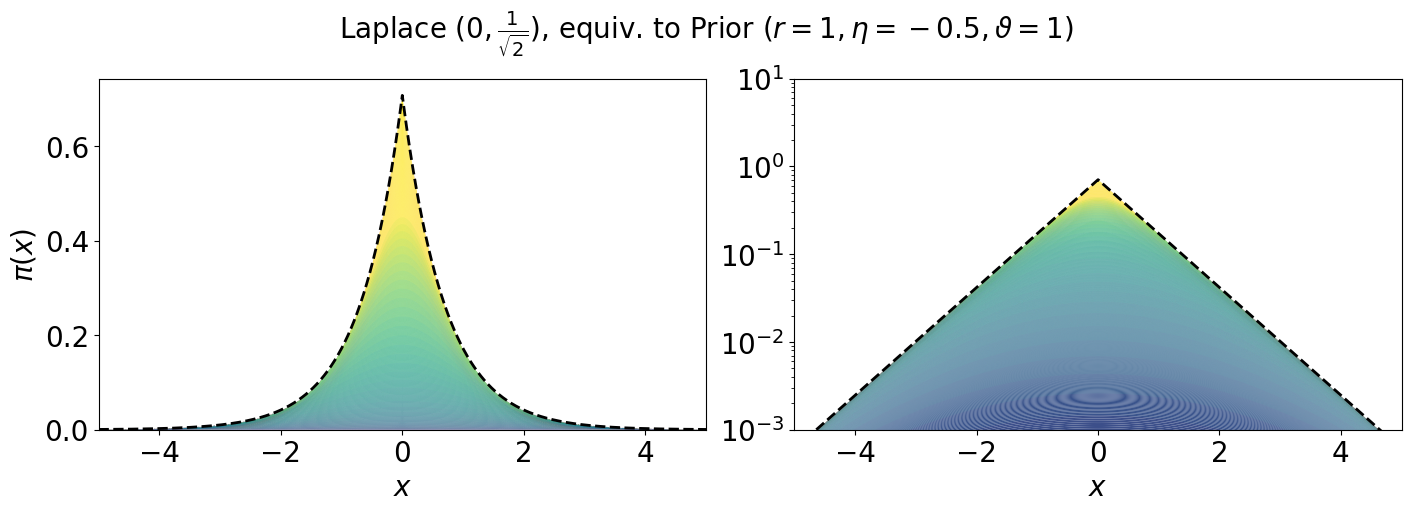

In [8]:
title = r'Laplace ($0, \frac{1}{\sqrt{2}}$), equiv. to Prior ($r=1, \eta=-0.5, \vartheta=1$)'
fig = plot_pdf_components(r=1, eta=-0.5, scale=1, components=3000, mode="equal", color_fn= color_fn,  xlim=(-5, 5),  log_lim=(1e-3, 10), title= title, debug=True, edgecolor= None)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_smooth_laplace.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

# Cauchy

In [9]:
# title = f'Scale Mixture of Normals with Cauchy Prior \n components={10}'
# fig = plot_pdf_components(r=-1, eta=-2, scale=1, components=10, mode="equal", color_fn= color_fn, xlim=(-5, 5),  log_lim=(1e-3, 10), debug=True, prior_pdf=stats.cauchy(0,np.sqrt(2)).pdf, title=title)
# if SAVE_FIGS:
#         save_path = os.path.join(plots_path, f"scale_mixture_cauchy.jpg")
#         fig.savefig(save_path, dpi=600, bbox_inches='tight')

In [10]:
title = r'Cauchy ($0, \sqrt(2)$), equiv. to Prior ($r=-1, \eta=-2, \vartheta=1$)'
fig = plot_pdf_components(r=-1, eta=-2, scale=1, components=3000, mode="equal", color_fn= color_fn, xlim=(-5, 5),  log_lim=(1e-3, 10), debug=True, prior_pdf=stats.cauchy(0,np.sqrt(2)).pdf, title=title, edgecolor= None)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_smooth_cauchy.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

[1.14667959e+07 2.86669849e+06 1.27408785e+06 ... 1.84703191e-01
 1.72703046e-01 1.55354824e-01]


ValueError: 
0, \sqrt(2)
        ^
ParseSyntaxException: Expected \sqrt{value}, found '('  (at char 8), (line:1, col:9)

Error in callback <function _draw_all_if_interactive at 0x7faab8508040> (for post_execute), with arguments args (),kwargs {}:


ValueError: 
0, \sqrt(2)
        ^
ParseSyntaxException: Expected \sqrt{value}, found '('  (at char 8), (line:1, col:9)

ValueError: 
0, \sqrt(2)
        ^
ParseSyntaxException: Expected \sqrt{value}, found '('  (at char 8), (line:1, col:9)

<Figure size 1400x500 with 2 Axes>

# Student T $\nu = 2$

[10.49205869  4.98328865  3.1401736   2.2124622   1.6497953   1.2682994
  0.98853213  0.76965527  0.58659693  0.41703239]


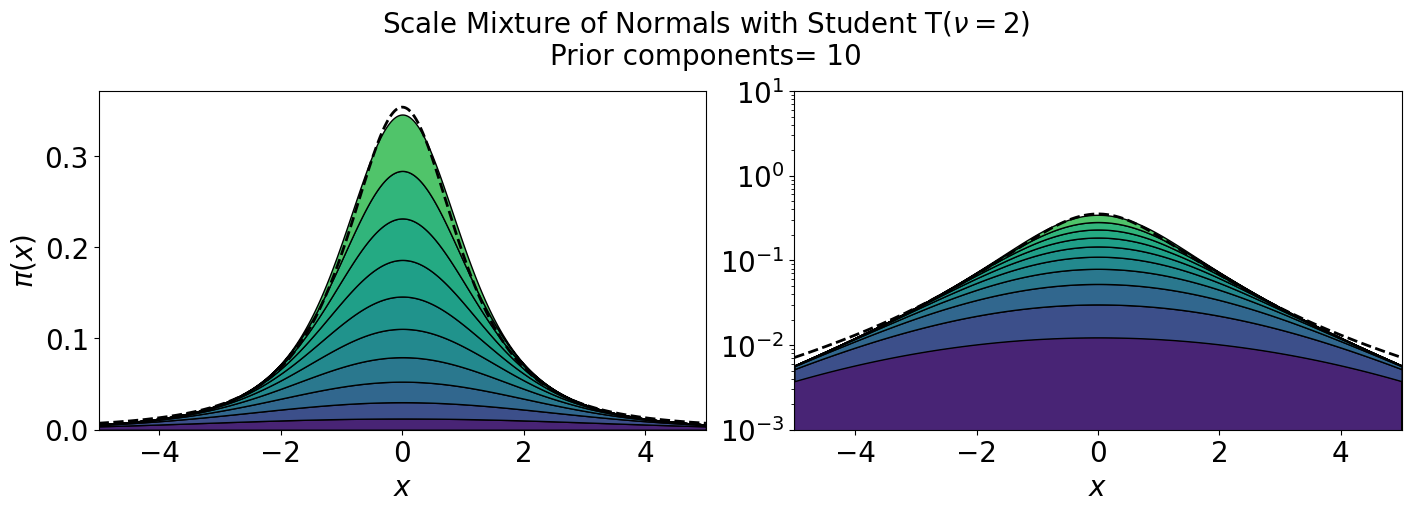

In [ ]:
# title = r'Scale Mixture of Normals with Student T($\nu = 2$)' + f'\nPrior components= 10'
# fig = plot_pdf_components(r=-1, eta=-2.5, scale=1, components=10, mode="equal", color_fn= color_fn, xlim=(-5, 5),  log_lim=(1e-3, 10), title =title, debug=True, prior_pdf=stats.t(df = 2).pdf)
# if SAVE_FIGS:
#         save_path = os.path.join(plots_path, f"scale_mixture_student_t.jpg")
#         fig.savefig(save_path, dpi=600, bbox_inches='tight')

[3.00049997e+03 1.49999994e+03 9.99833250e+02 ... 1.44757843e-01
 1.36732435e-01 1.24895387e-01]


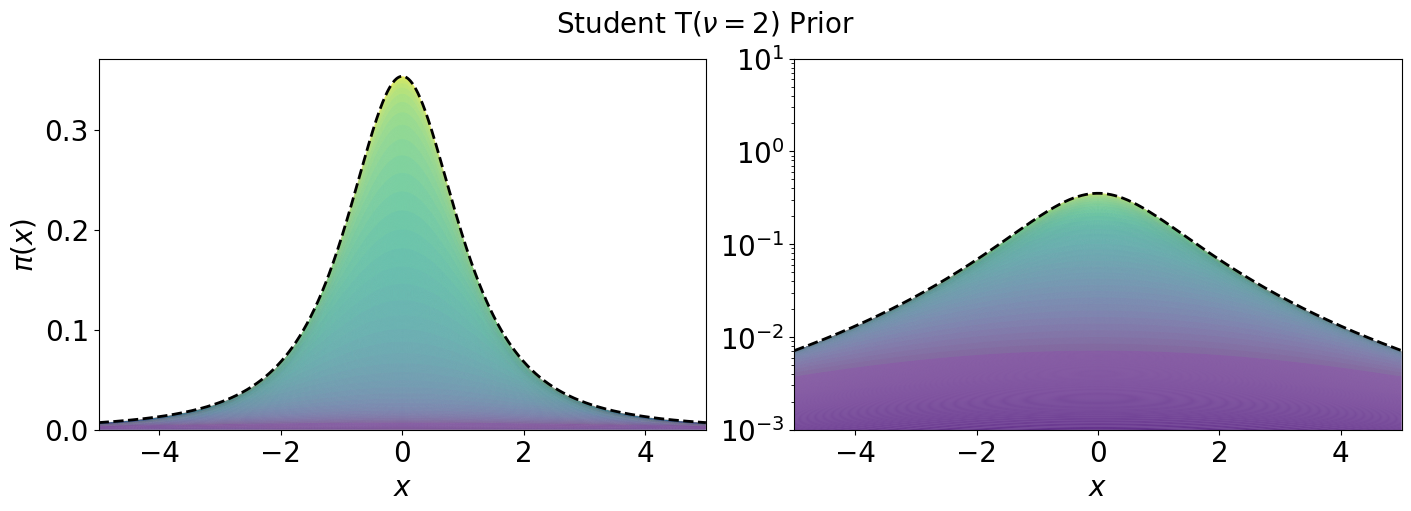

In [ ]:
title = r'Student T($\nu = 2$) Prior'
fig = plot_pdf_components(r=-1, eta=-2.5, scale=1, components=3000, mode="equal", color_fn= color_fn, xlim=(-5, 5),  log_lim=(1e-3, 10), title =title, debug=True, prior_pdf=stats.t(df = 2).pdf, edgecolor= None)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_smooth_student_t.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

# A

Params: 1, -1
Chebyshev bound: 22.360679774997898
No tail


  0%|          | 0/100 [00:00<?, ?it/s]

Maximum Diff in y-values: 0.23174782347923567


  0%|          | 0/100 [00:00<?, ?it/s]

Maximum Diff in y-values with new points: 0.013479621016869892
First CDF value: 1.2854592126570933e-15
Last CDF value: 0.9999999999999987
Tail bound: 0.001
KstestResult(statistic=0.00904126406467215, pvalue=0.38478732804043236, statistic_location=-0.004824702608839171, statistic_sign=1)
[1.42910075 0.89134979 0.60148903 0.41264785 0.27964624 0.18276172
 0.11176478 0.06081527 0.02642335 0.00651914]


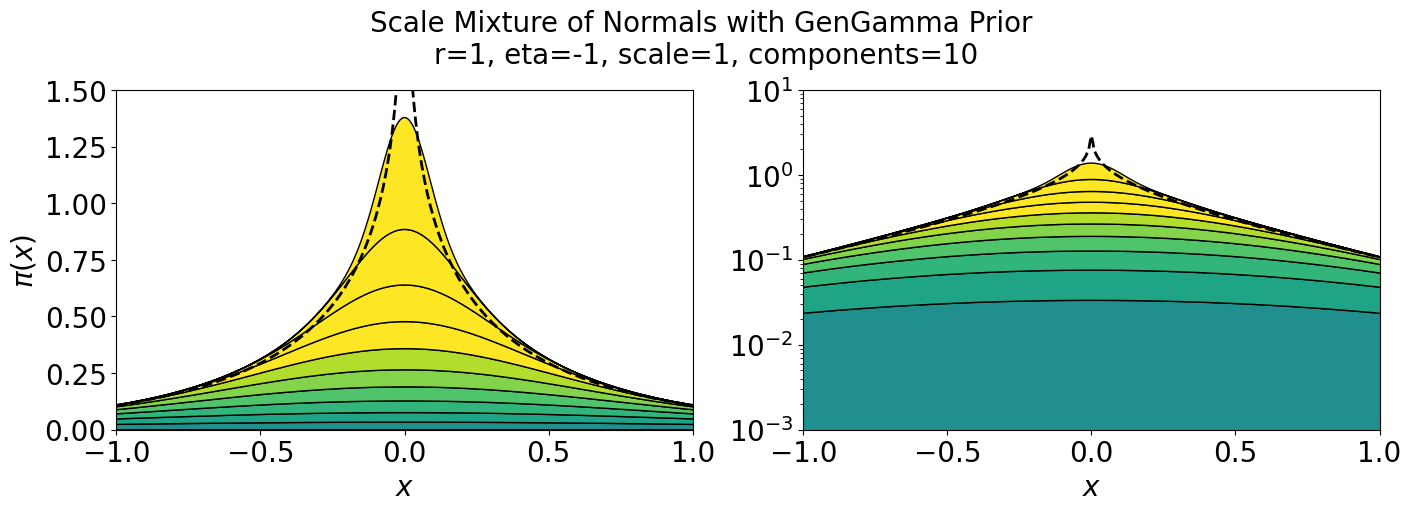

In [ ]:
# title = f'Scale Mixture of Normals with GenGamma Prior \nr=1, eta=-1, scale=1, components={10}'
# fig = plot_pdf_components(r=1, eta=-1, scale=1, components=10, mode="equal", color_fn= color_fn, xlim=(-1, 1),  lin_lim= [0, 1.5], log_lim=(1e-3, 10), title = title,  debug=True)
# if SAVE_FIGS:
#         save_path = os.path.join(plots_path, f"scale_mixture_r=1_eta=1_scale=1.jpg")
#         fig.savefig(save_path, dpi=600, bbox_inches='tight')

Params: 1, -1
Chebyshev bound: 22.360679774997898
No tail


  0%|          | 0/100 [00:00<?, ?it/s]

Maximum Diff in y-values: 0.23174782347923567


  0%|          | 0/100 [00:00<?, ?it/s]

Maximum Diff in y-values with new points: 0.013479621016869892
First CDF value: 1.2854592126570933e-15
Last CDF value: 0.9999999999999987
Tail bound: 0.001
KstestResult(statistic=0.013070252303161944, pvalue=0.06507044857442645, statistic_location=0.1604905211351385, statistic_sign=-1)
[6.43687770e+00 5.79028581e+00 5.41409162e+00 ... 7.84875237e-07
 3.48833337e-07 8.72083191e-08]


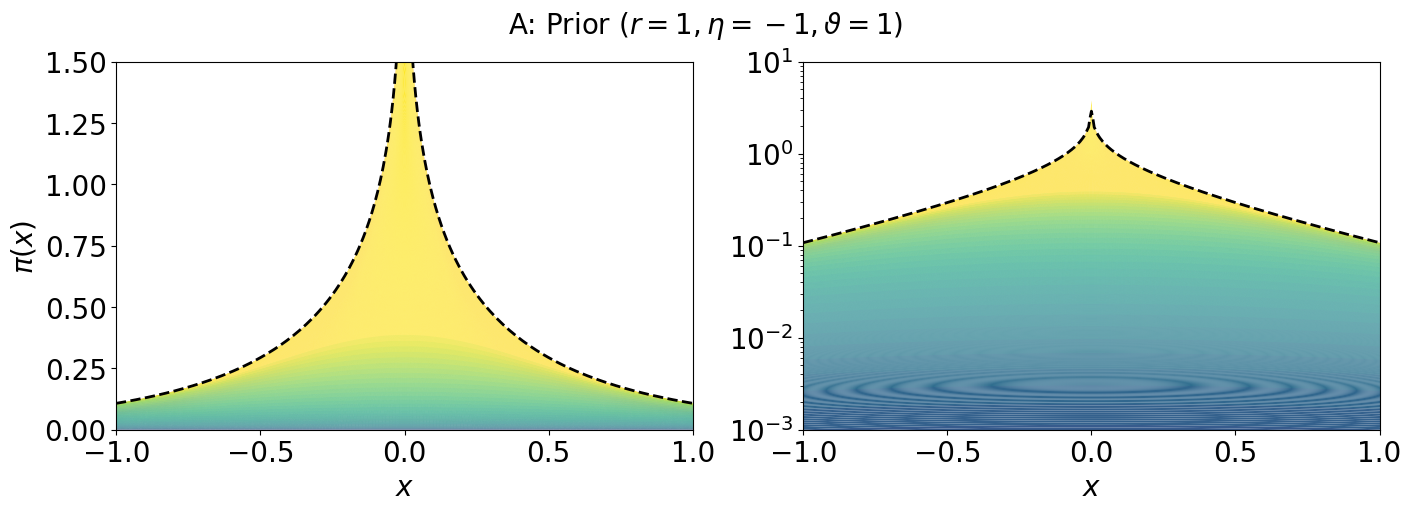

In [ ]:
title = r'A: Prior ($r=1, \eta=-1, \vartheta=1$)'
fig = plot_pdf_components(r=1, eta=-1, scale=1, components=3000, mode="equal", color_fn= color_fn, xlim=(-1, 1),  lin_lim= [0, 1.5], log_lim=(1e-3, 10), title = title, debug=True, edgecolor= None)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_smooth_r=1_eta=1_scale=1.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

# B

Params: 1, 2
Chebyshev bound: 59.16079783099616
No tail


  0%|          | 0/100 [00:00<?, ?it/s]

Maximum Diff in y-values: 0.13940224348708696
First CDF value: 7.884039416526217e-34
Last CDF value: 1.0
Tail bound: 0.001
KstestResult(statistic=0.007960169014536722, pvalue=0.5479261659868693, statistic_location=-0.5710737186224304, statistic_sign=-1)
[6.15342118 5.06051277 4.36433898 3.82941643 3.37880905 2.97561873
 2.59674593 2.22273726 1.82916556 1.3632966 ]


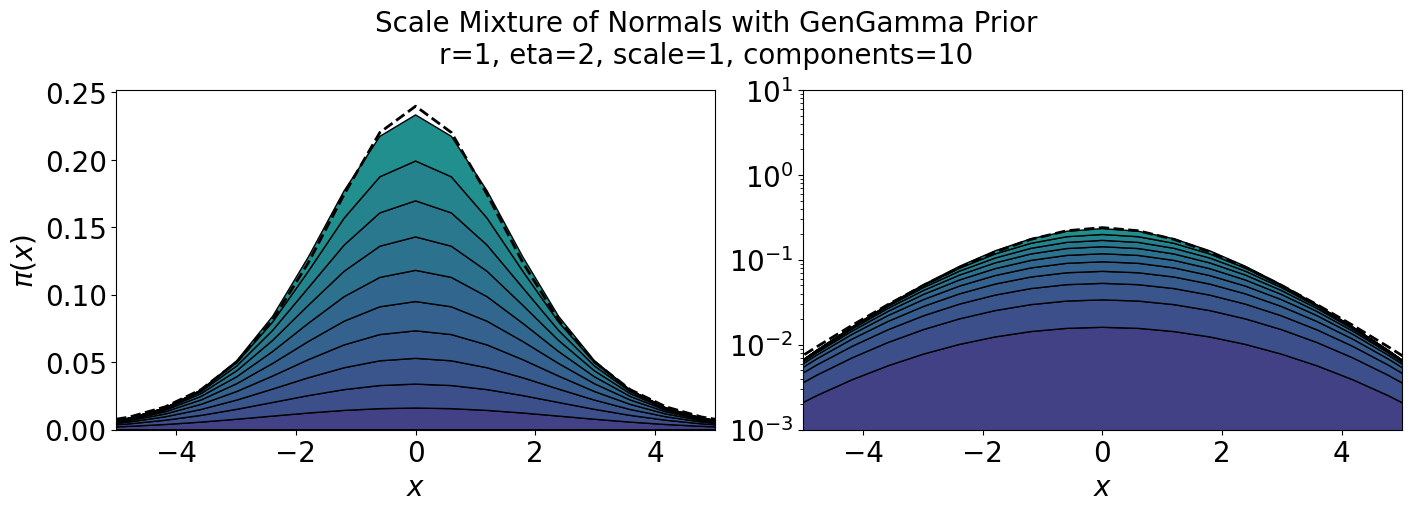

In [ ]:
# title = f'Scale Mixture of Normals with GenGamma Prior \nr=1, eta=2, scale=1, components={10}'
# fig = plot_pdf_components(r=1, eta=2, scale=1, components=10, mode="equal", color_fn= color_fn, xlim=(-5, 5),  log_lim=(1e-3, 10), debug=True)
# if SAVE_FIGS:
#         save_path = os.path.join(plots_path, f"scale_mixture_r=1_eta=2_scale=1.jpg")
#         fig.savefig(save_path, dpi=600, bbox_inches='tight')

Params: 1, 2
Chebyshev bound: 59.16079783099616
No tail


  0%|          | 0/100 [00:00<?, ?it/s]

Maximum Diff in y-values: 0.13940224348708696
First CDF value: 7.884039416526217e-34
Last CDF value: 1.0
Tail bound: 0.001
KstestResult(statistic=0.011585539199833239, pvalue=0.13541623732232966, statistic_location=-0.15088113099445916, statistic_sign=-1)
[13.50020905 12.65876805 12.16135375 ...  0.29921638  0.26445895
  0.21457699]


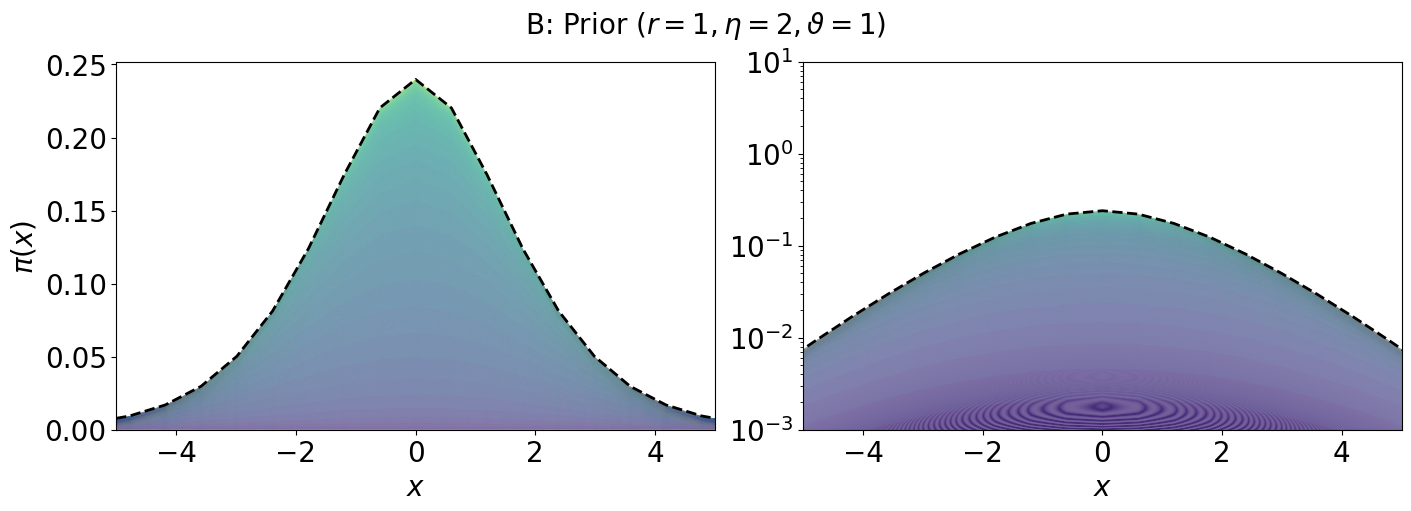

In [ ]:
title = r'B: Prior ($r=1, \eta=2, \vartheta=1$)'
fig = plot_pdf_components(r=1, eta=2, scale=1, components=3000, mode="equal", color_fn= color_fn, xlim=(-5, 5),  log_lim=(1e-3, 10), title= title, debug=True, edgecolor= None)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_smooth_r=1_eta=2_scale=1.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

# C

Params: 0.2, 2
Chebyshev bound: 52749.500886264315
Tail samples: 20


  0%|          | 0/100 [00:00<?, ?it/s]

Maximum Diff in y-values: 0.060031294891367076
First CDF value: 3.8212144969303474e-10
Last CDF value: 0.9999999996178786
Tail bound: 0.001
KstestResult(statistic=0.007186937586164399, pvalue=0.6771417326100795, statistic_location=355.5488721437648, statistic_sign=1)
[6866734.00980798 4287767.32358619 3036950.46092983 2257054.35323129
 1710206.89923941 1298842.76200087  973900.68296481  706966.20395157
  478984.45116497  272631.42368993]


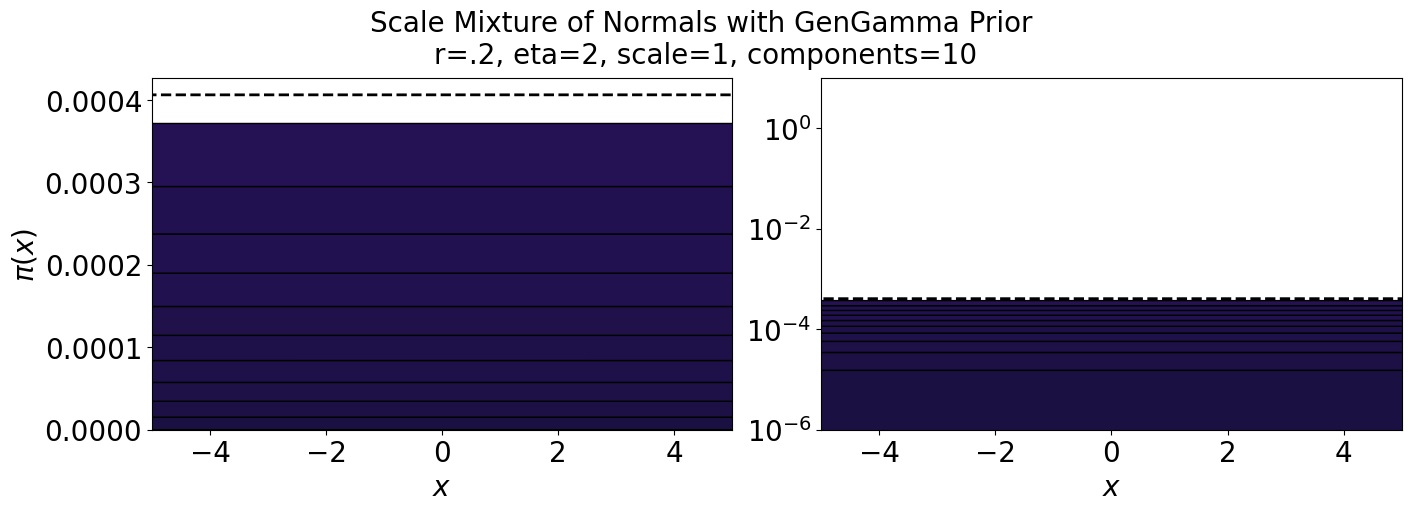

In [ ]:
# title = f'Scale Mixture of Normals with GenGamma Prior \nr=.2, eta=2, scale=1, components={10}'
# fig = plot_pdf_components(r=.2, eta=2, scale=1, components=10, xlim = [-5, 5], color_fn= color_fn, log_lim = (1e-6, 10), title =title, mode="equal", debug=True)
# if SAVE_FIGS:
#         save_path = os.path.join(plots_path, f"scale_mixture_r=0.2_eta=2_scale=1.jpg")
#         fig.savefig(save_path, dpi=600, bbox_inches='tight')

Params: 0.2, 2
Chebyshev bound: 52749.500886264315
Tail samples: 20


  0%|          | 0/100 [00:00<?, ?it/s]

Maximum Diff in y-values: 0.060031294891367076
First CDF value: 3.8212144969303474e-10
Last CDF value: 0.9999999996178786
Tail bound: 0.001
KstestResult(statistic=0.010247566780837325, pvalue=0.2427464432262344, statistic_location=-932.5847357449095, statistic_sign=1)
[5.51021976e+07 4.59000532e+07 4.10087041e+07 ... 2.13586320e+04
 1.77262403e+04 1.30025930e+04]


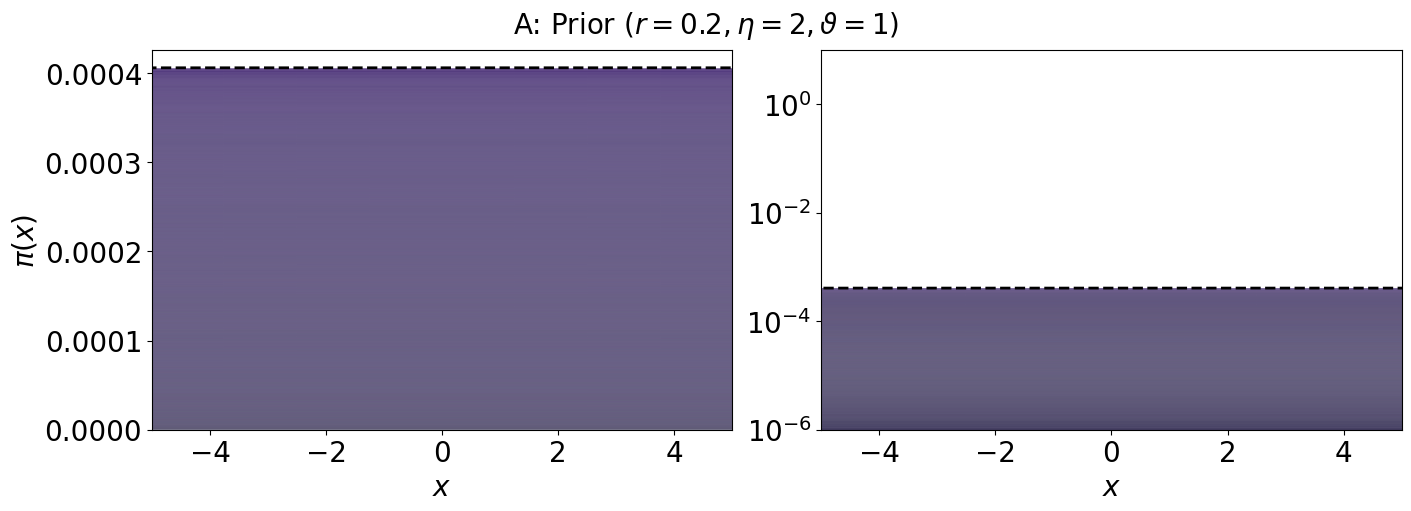

In [ ]:
title = r'C: Prior ($r=0.2, \eta=2, \vartheta=1$)'
fig = plot_pdf_components(r=0.2, eta=2, scale=1, components=3000, xlim = [-5, 5], color_fn= color_fn, log_lim = (1e-6, 10), title = title, mode="equal", debug=True , edgecolor= None)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_smooth_r=0.2_eta=2_scale=1.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')

# D

Params: 5, 5
Chebyshev bound: 31.424062636117622
No tail


  0%|          | 0/100 [00:00<?, ?it/s]

Maximum Diff in y-values: 0.12722235773783913
First CDF value: 9.57046655155066e-130
Last CDF value: 1.0
Tail bound: 0.001
KstestResult(statistic=0.00783301944223358, pvalue=0.5687918967863592, statistic_location=-0.7979540845408427, statistic_sign=1)
[1.23810757 1.16524894 1.11103617 1.06384024 1.01930164 0.97478324
 0.92789649 0.87549071 0.81170066 0.71994407]


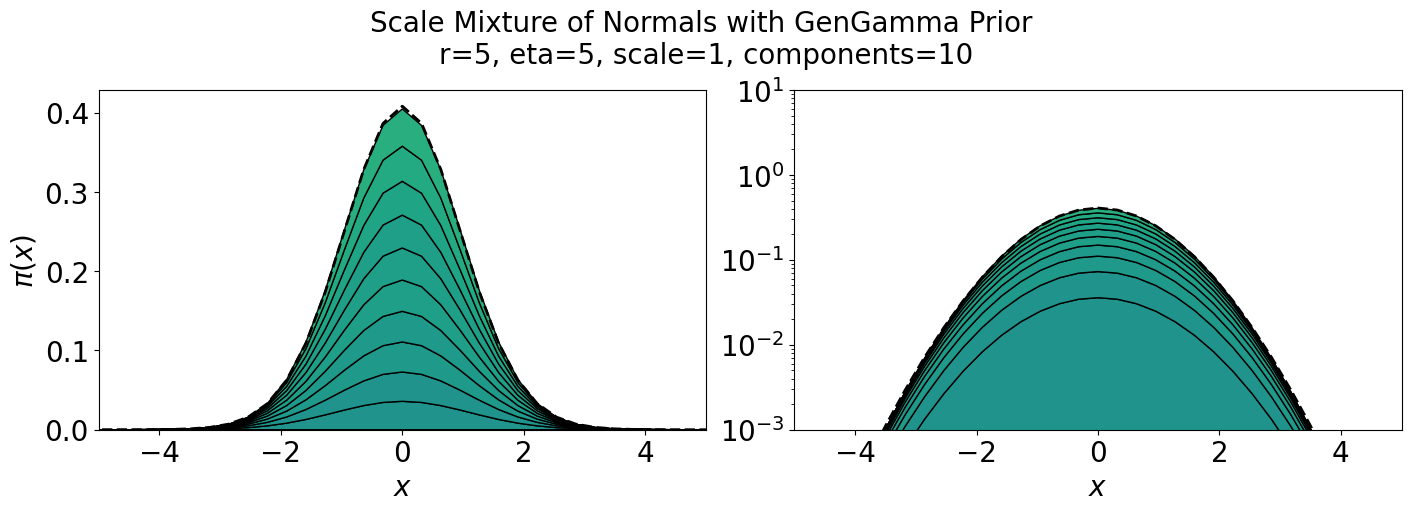

In [ ]:
# title = f'Scale Mixture of Normals with GenGamma Prior \nr=5, eta=5, scale=1, components={10}'
# fig = plot_pdf_components(r=5, eta=5, scale=1, components=10, mode="equal", color_fn= color_fn, title = title, xlim=(-5, 5), log_lim=(1e-3, 10), debug=True)
# if SAVE_FIGS:
#         save_path = os.path.join(plots_path, f"scale_mixture_r=5_eta=5_scale=1.jpg")
#         fig.savefig(save_path, dpi=600, bbox_inches='tight')

Params: 5, 5
Chebyshev bound: 31.424062636117622
No tail


  0%|          | 0/100 [00:00<?, ?it/s]

Maximum Diff in y-values: 0.12722235773783913
First CDF value: 9.57046655155066e-130
Last CDF value: 1.0
Tail bound: 0.001
KstestResult(statistic=0.010338296019354709, pvalue=0.23387630401089032, statistic_location=-0.524154386053133, statistic_sign=1)
[1.5448354  1.51882913 1.50271443 ... 0.35395749 0.33250935 0.29883267]


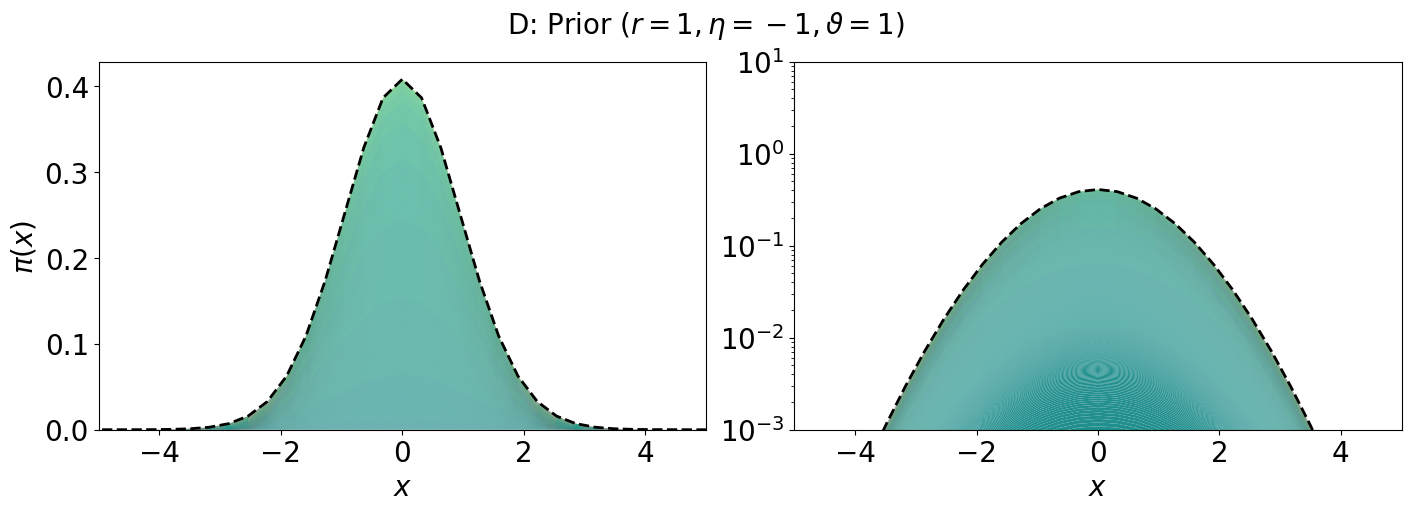

In [ ]:
title = r'D: Prior ($r=1, \eta=-1, \vartheta=1$)'
fig = plot_pdf_components(r=5, eta=5, scale=1, components=3000, mode="equal", title = title, color_fn= color_fn, xlim=(-5, 5), log_lim=(1e-3, 10), debug=True, edgecolor= None)
if SAVE_FIGS:
        save_path = os.path.join(plots_path, f"scale_mixture_smooth_r=5_eta=5_scale=1.jpg")
        fig.savefig(save_path, dpi=600, bbox_inches='tight')